# Behavioural data

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import os
import glob
import matplotlib.cm as cm
import numpy as np

In [90]:
file_paths = glob.glob(os.path.join("..", "..", "workshop_data", "behavioural_logs",'*.csv'), recursive=True)

## Preprocessing

In [ ]:
# Combining all csv files into one df
combined_df = pd.concat([pd.read_csv(fp, index_col=False) for fp in file_paths])

# shifting trial and staircase by adding 1
combined_df['trial_number']=combined_df['trial_number']+1
combined_df['staircase_number']=combined_df['staircase_number']+1
# Creating a 'correct' column containing a boolean
combined_df['correct'] = combined_df['objective_response'] == combined_df['target_type']
# Creating cummulative number of correct answers
combined_df['cumulative_correct'] = combined_df.groupby('subject')['correct'].cumsum()
# Creating overall trial number 
combined_df['trial_index'] = combined_df.groupby('subject').cumcount() + 1 # Starts at 0
# Calculating accuracy over time
combined_df['accuracy'] = combined_df['cumulative_correct'] / combined_df['trial_index']


# sanity check
combined_df.head()


,subject,trial_number,staircase_number,fixation_duration_ms,target_duration_ms,target_type,target_contrast,mask_duration_ms,objective_response,objective_response_time_ms,subjective_response,subjective_response_time_ms,correct,cumulative_correct,trial_index,accuracy
0,169,1,1,716.666667,33.333333,stimulus_1,0.400000,33.333333,stimulus_1,2.149918,1,2.160107,True,1,1,1.000000
1,169,2,1,700.000000,33.333333,stimulus_1,0.250988,33.333333,stimulus_1,3.338549,1,1.488952,True,2,2,1.000000
2,169,3,1,566.666667,33.333333,stimulus_0,0.153029,33.333333,stimulus_1,1.027541,1,0.921889,False,2,3,0.666667
3,169,4,1,733.333333,33.333333,stimulus_0,0.286338,33.333333,stimulus_1,2.111574,1,1.767445,False,2,4,0.500000
4,169,5,1,575.000000,33.333333,stimulus_0,0.374182,33.333333,stimulus_0,1.269429,2,2.939059,True,3,5,0.600000


## Plots

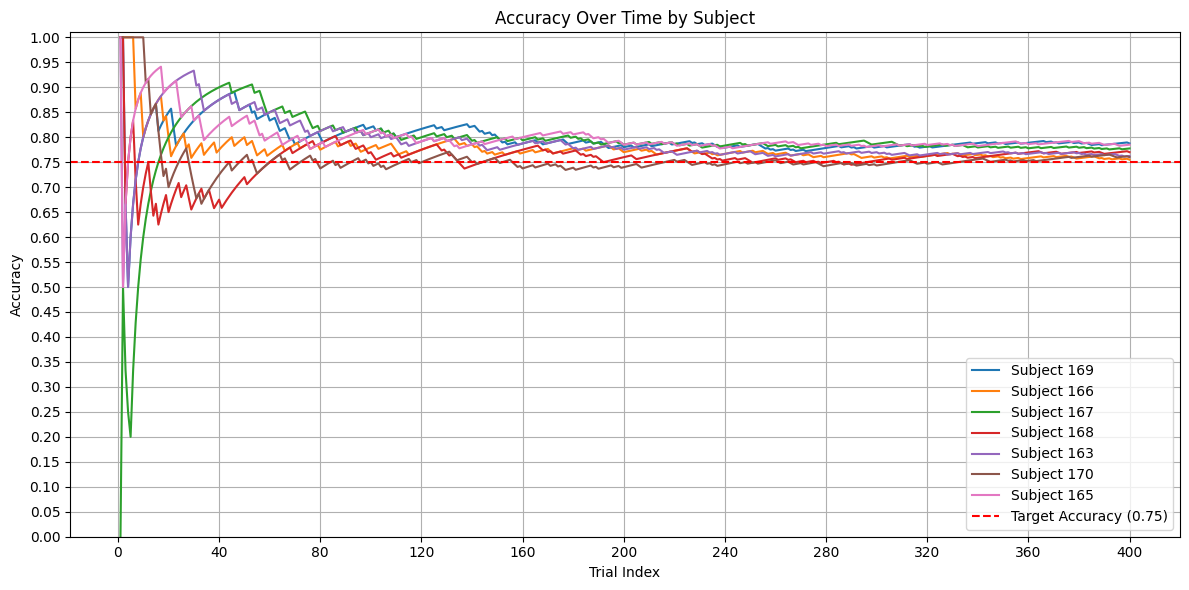

In [ ]:

plt.figure(figsize=(12, 6))

# Looping through each subject and ploting their accuracy over time
for subject in combined_df['subject'].unique():
    subject_data = combined_df[combined_df['subject'] == subject]
    plt.plot(
        subject_data['trial_index'],
        subject_data['accuracy'],
        label=f'Subject {subject}'
    )

# Adding a horizontal reference line at 0.75 accuracy -> supposed target
plt.axhline(y=0.75, color='red', linestyle='--', linewidth=1.5, label='Target Accuracy (0.75)')

# Axis labels and title
plt.xlabel('Trial Index')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Time by Subject')

# Ticks and grid
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(40))
ax.yaxis.set_major_locator(MultipleLocator(0.05))
ax.set_ylim(0,1.01)
plt.grid(True)

# Legend and layout
plt.legend()
plt.tight_layout()
plt.show()

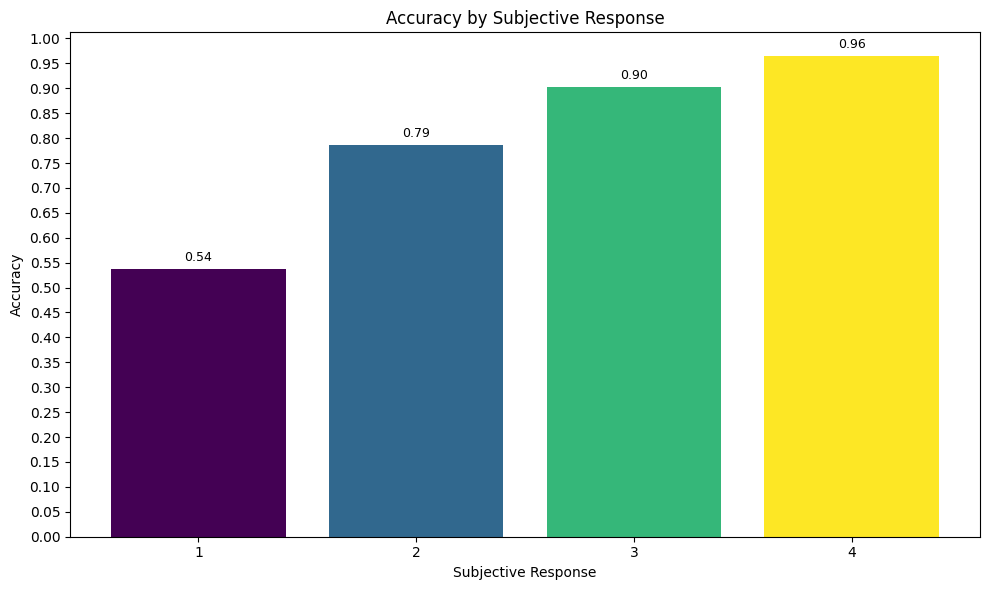

In [ ]:
# Accuracy by subjective response
accuracy_by_response = (
    combined_df
    .groupby('subjective_response')['correct']
    .agg(['sum', 'count'])  # sum - how many times correct == True (i.e., correct responses), count = total trials
    .rename(columns={'sum': 'correct_count', 'count': 'total_count'})
)

accuracy_by_response['accuracy'] = accuracy_by_response['correct_count'] / accuracy_by_response['total_count']


# making a colormap from scratch using (e.g., 'viridis')
num_bars = len(accuracy_by_response)
colors = cm.viridis(np.linspace(0, 1, num_bars))

# Plotting bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(
    accuracy_by_response.index,
    accuracy_by_response['accuracy'],
    color=colors
)

# Annotating bars with accuracy values
for bar, acc in zip(bars, accuracy_by_response['accuracy']):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.01,
        f"{acc:.2f}",
        ha='center',
        va='bottom',
        fontsize=9
    )

# Axis labels and styling
plt.xlabel('Subjective Response')
plt.ylabel('Accuracy')
plt.title('Accuracy by Subjective Response')
plt.xticks(rotation=0)

# Tick spacing
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(0.05))

plt.tight_layout()
plt.show()

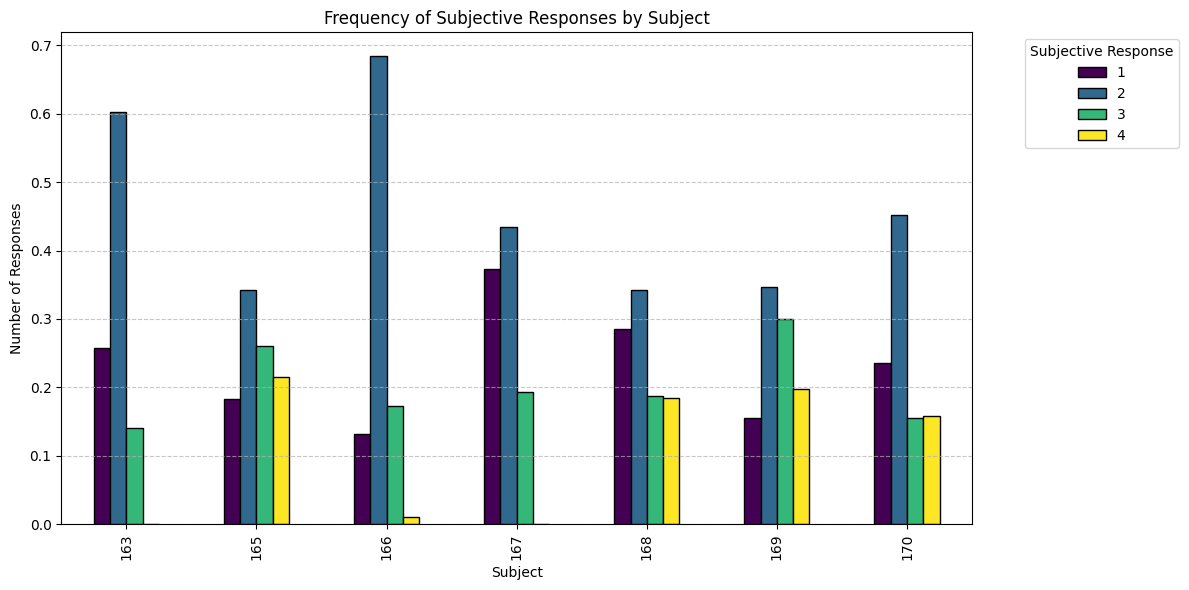

In [102]:
# Counting how many times each subject gave each subjective response
response_counts = (
    combined_df
    .groupby(['subject', 'subjective_response'])
    .size()
    .unstack(fill_value=0)  # Converts to wide format: rows = subjects, columns = responses
)

# Plotting grouped bar chart
(response_counts/400).plot(
    kind='bar',
    figsize=(12, 6),
    colormap='viridis',
    edgecolor='black'
)

plt.xlabel('Subject')
plt.ylabel('Number of Responses')
plt.title('Frequency of Subjective Responses by Subject')
plt.legend(title='Subjective Response', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
